In [1]:
!nvidia-smi

Thu Feb 22 21:41:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   53C    P8              23W / 215W |   1780MiB /  8192MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/linh/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [7]:
data_dir = '../data/CREMA-D/'

In [8]:
sr = 16000

x_train = np.load(f'{data_dir}crema_d.audio16k.train.npy', allow_pickle=True)
x_test = np.load(f'{data_dir}crema_d.audio16k.test.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_dir}crema_d.labels.train.npy', allow_pickle=True)
y_test = np.load(f'{data_dir}crema_d.labels.test.npy', allow_pickle=True)

In [9]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in y_train]
x_train = x_train[filtered_idx]
y_train = [label_to_index(idx) for idx in y_train[filtered_idx]]
print(x_train.shape)

filtered_idx = [label_filter(idx) for idx in y_test]
x_test = x_test[filtered_idx]
y_test = [label_to_index(idx) for idx in y_test[filtered_idx]]
print(x_test.shape)

(3387,)
(1025,)


In [10]:
l = [len(i) for i in x_train]
print(min(l))
print(max(l))
sum(l) / len(l)

21355
80080


39776.52967227635

In [11]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [12]:
sample_rate=16000

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=3, sample_rate=16000):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 32

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
from IConNet.nn.model import M12

In [15]:
from omegaconf import OmegaConf as ocf

In [16]:
import traceback

In [17]:
model_config_path = 'config/model/m12_debug.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M12_debug', 'description': 'FirConv sequential for iemocap', 'fe': {'n_block': 2, 'n_channel': [64, 32], 'kernel_size': [63, 31], 'stride': [4, 4], 'window_k': [5, 9], 'residual_connection_type': 'stack', 'pooling': False, 'filter_type': 'firwin', 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'seq': {'n_block': 1, 'n_channel': 48, 'pooling': 'max', 'use_context': False, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256], 'norm_type': 'LayerNorm'}}

In [18]:
model = M12(config=model_config,
           n_input=1, n_output=len(labels))
model

M12(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (seq_blocks): Seq2OneBlocks(
    (blocks): LSTM(97, 48, batch_first=True)
  )
  (cls_hea

In [19]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [20]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [21]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▎                                                                                                                                                                             | 0.014598540145985401/10 [00:00<07:05, 42.59s/it]

Train Epoch: 1 [0/3387 (0%)]	Loss: 1.399542
Mem before-during-after: 529408 1929976320 21018112


  3%|█████▍                                                                                                                                                                          | 0.3065693430656933/10 [00:10<05:16, 32.60s/it]

Train Epoch: 1 [1280/3387 (38%)]	Loss: 0.980688
Mem before-during-after: 21018112 1938932224 21018112


  6%|██████████▌                                                                                                                                                                      | 0.598540145985401/10 [00:19<05:07, 32.71s/it]

Train Epoch: 1 [2560/3387 (76%)]	Loss: 1.029866
Mem before-during-after: 21018112 1940229120 21018112


 10%|█████████████████▋                                                                                                                                                               | 0.999999999999999/10 [00:31<03:52, 25.89s/it]


Test Epoch: 1	Accuracy: 619/1024 (60%)



 10%|█████████████████▊                                                                                                                                                              | 1.0145985401459845/10 [00:31<03:57, 26.40s/it]

Train Epoch: 2 [0/3387 (0%)]	Loss: 0.949221
Mem before-during-after: 21014016 1936212480 21018112


 13%|██████████████████████▉                                                                                                                                                         | 1.3065693430656966/10 [00:40<04:35, 31.68s/it]

Train Epoch: 2 [1280/3387 (38%)]	Loss: 1.128754
Mem before-during-after: 21018112 1940360192 21018112


 16%|████████████████████████████▏                                                                                                                                                   | 1.5985401459854087/10 [00:50<04:29, 32.13s/it]

Train Epoch: 2 [2560/3387 (76%)]	Loss: 0.865661
Mem before-during-after: 21018112 1938309632 21018112


 20%|███████████████████████████████████▍                                                                                                                                             | 2.000000000000013/10 [01:01<03:16, 24.51s/it]


Test Epoch: 2	Accuracy: 625/1024 (61%)



 20%|███████████████████████████████████▋                                                                                                                                             | 2.014598540145998/10 [01:02<03:28, 26.14s/it]

Train Epoch: 3 [0/3387 (0%)]	Loss: 0.783523
Mem before-during-after: 21014016 1936212480 21018112


 23%|████████████████████████████████████████▌                                                                                                                                       | 2.3065693430657013/10 [01:11<04:07, 32.20s/it]

Train Epoch: 3 [1280/3387 (38%)]	Loss: 0.744044
Mem before-during-after: 21018112 1939723264 21018112


 26%|█████████████████████████████████████████████▋                                                                                                                                  | 2.5985401459854045/10 [01:21<03:55, 31.79s/it]

Train Epoch: 3 [2560/3387 (76%)]	Loss: 0.924652
Mem before-during-after: 21018112 1939723264 21018112


 30%|████████████████████████████████████████████████████▊                                                                                                                           | 2.9999999999999964/10 [01:32<02:51, 24.50s/it]


Test Epoch: 3	Accuracy: 626/1024 (61%)



 30%|█████████████████████████████████████████████████████                                                                                                                           | 3.0145985401459816/10 [01:32<03:08, 26.94s/it]

Train Epoch: 4 [0/3387 (0%)]	Loss: 0.958624
Mem before-during-after: 21014016 1941400576 21018112


 33%|██████████████████████████████████████████████████████████                                                                                                                      | 3.2992700729926923/10 [01:42<03:52, 34.72s/it]

Train Epoch: 4 [1280/3387 (38%)]	Loss: 0.932109
Mem before-during-after: 21018112 1940239360 21018112


 36%|███████████████████████████████████████████████████████████████▋                                                                                                                 | 3.598540145985388/10 [01:51<03:27, 32.48s/it]

Train Epoch: 4 [2560/3387 (76%)]	Loss: 0.869222
Mem before-during-after: 21018112 1940239360 21018112


 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                          | 3.99999999999998/10 [02:03<02:26, 24.40s/it]


Test Epoch: 4	Accuracy: 610/1024 (60%)



 40%|███████████████████████████████████████████████████████████████████████                                                                                                          | 4.014598540145966/10 [02:03<02:34, 25.84s/it]

Train Epoch: 5 [0/3387 (0%)]	Loss: 0.890472
Mem before-during-after: 21014016 1941400576 21018112


 43%|████████████████████████████████████████████████████████████████████████████                                                                                                     | 4.299270072992694/10 [02:12<03:19, 34.95s/it]

Train Epoch: 5 [1280/3387 (38%)]	Loss: 0.873305
Mem before-during-after: 21018112 1940239360 21018112


 46%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 4.598540145985408/10 [02:22<02:53, 32.15s/it]

Train Epoch: 5 [2560/3387 (76%)]	Loss: 0.805819
Mem before-during-after: 21018112 1940239360 21018112


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5.000000000000024/10 [02:33<02:08, 25.78s/it]


Test Epoch: 5	Accuracy: 642/1024 (63%)



 50%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 5.01459854014601/10 [02:34<02:13, 26.79s/it]

Train Epoch: 6 [0/3387 (0%)]	Loss: 0.816609
Mem before-during-after: 21014016 1941400576 21018112


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 5.299270072992738/10 [02:43<02:47, 35.55s/it]

Train Epoch: 6 [1280/3387 (38%)]	Loss: 1.112787
Mem before-during-after: 21018112 1940239360 21018112


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 5.598540145985452/10 [02:53<03:08, 42.82s/it]

Train Epoch: 6 [2560/3387 (76%)]	Loss: 0.895323
Mem before-during-after: 21018112 1940239360 21018112


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 6.000000000000068/10 [03:05<01:36, 24.05s/it]


Test Epoch: 6	Accuracy: 632/1024 (62%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 6.014598540146054/10 [03:05<01:44, 26.19s/it]

Train Epoch: 7 [0/3387 (0%)]	Loss: 0.754950
Mem before-during-after: 21014016 1941400576 21018112


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 6.306569343065775/10 [03:15<02:00, 32.50s/it]

Train Epoch: 7 [1280/3387 (38%)]	Loss: 0.885937
Mem before-during-after: 21018112 1940239360 21018112


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6.591240875912503/10 [03:24<02:00, 35.23s/it]

Train Epoch: 7 [2560/3387 (76%)]	Loss: 0.941533
Mem before-during-after: 21018112 1940239360 21018112


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7.000000000000113/10 [03:35<01:11, 23.79s/it]


Test Epoch: 7	Accuracy: 572/1024 (56%)



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 7.014598540146099/10 [03:36<01:16, 25.50s/it]

Train Epoch: 8 [0/3387 (0%)]	Loss: 1.019176
Mem before-during-after: 21014016 1941400576 21018112


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 7.30656934306582/10 [03:45<01:25, 31.67s/it]

Train Epoch: 8 [1280/3387 (38%)]	Loss: 1.261851
Mem before-during-after: 21018112 1940239360 21018112


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7.598540145985541/10 [03:55<01:20, 33.49s/it]

Train Epoch: 8 [2560/3387 (76%)]	Loss: 0.946940
Mem before-during-after: 21018112 1940239360 21018112


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8.000000000000156/10 [04:06<00:47, 23.62s/it]


Test Epoch: 8	Accuracy: 658/1024 (64%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 8.014598540146142/10 [04:06<00:50, 25.42s/it]

Train Epoch: 9 [0/3387 (0%)]	Loss: 0.946385
Mem before-during-after: 21014016 1936212480 21018112


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 8.306569343065863/10 [04:16<00:54, 32.43s/it]

Train Epoch: 9 [1280/3387 (38%)]	Loss: 0.705323
Mem before-during-after: 21018112 1939723264 21018112


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8.598540145985584/10 [04:25<00:43, 31.18s/it]

Train Epoch: 9 [2560/3387 (76%)]	Loss: 1.007762
Mem before-during-after: 21018112 1939723264 21018112


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 9.0000000000002/10 [04:37<00:26, 26.10s/it]


Test Epoch: 9	Accuracy: 628/1024 (61%)



 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 9.014598540146187/10 [04:37<00:27, 28.16s/it]

Train Epoch: 10 [0/3387 (0%)]	Loss: 0.950375
Mem before-during-after: 21014016 1941400576 21018112


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9.306569343065908/10 [04:47<00:22, 32.19s/it]

Train Epoch: 10 [1280/3387 (38%)]	Loss: 1.104173
Mem before-during-after: 21018112 1938309632 21018112


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9.598540145985629/10 [04:56<00:12, 32.10s/it]

Train Epoch: 10 [2560/3387 (76%)]	Loss: 0.838257
Mem before-during-after: 21018112 1940239360 21018112


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9.992700729927252/10 [05:07<00:00, 23.99s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10.000000000000245/10 [05:08<00:00, 30.80s/it]


Test Epoch: 10	Accuracy: 613/1024 (60%)



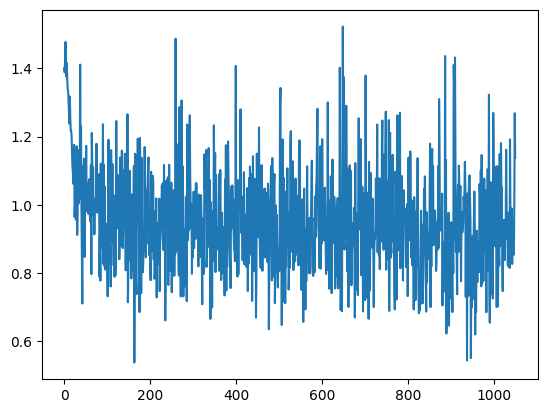

In [22]:
plt.plot(train_losses)

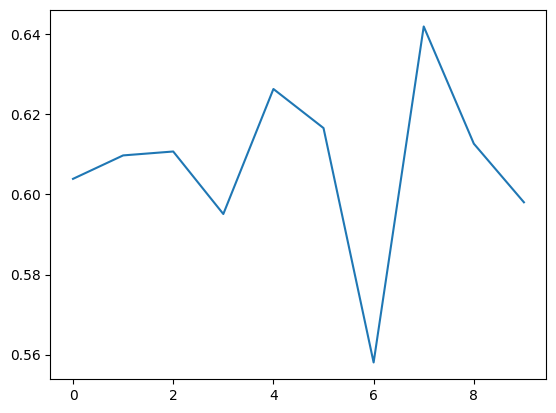

In [23]:
plt.plot(test_accuracy)

In [24]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s': MulticlassF1Score(num_classes=n),  
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc': MulticlassAUROC(num_classes=n, average=None, thresholds=None)
    }
    # , compute_groups=[['acc', 'f1s', 'wap'], ['uap', 'uar']]
                              ).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [25]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 613/1024 (0.5986)
{'acc_detail': tensor([0.5414, 0.3684, 0.8981, 0.5547], device='cuda:0'),
 'acc_unweighted': tensor(0.5907, device='cuda:0'),
 'acc_weighted': tensor(0.5986, device='cuda:0'),
 'f1s': tensor(0.5832, device='cuda:0'),
 'f1s_detail': tensor([0.6545, 0.4190, 0.7267, 0.5326], device='cuda:0'),
 'precision_detail': tensor([0.8276, 0.4855, 0.6103, 0.5122], device='cuda:0'),
 'recall_detail': tensor([0.5414, 0.3684, 0.8981, 0.5547], device='cuda:0'),
 'rocauc': tensor([0.9259, 0.8319, 0.9366, 0.7636], device='cuda:0'),
 'uar': tensor(0.5907, device='cuda:0'),
 'wap': tensor(0.6136, device='cuda:0')}


tensor([[144,  18,   7,  97],
        [  1,  84, 105,  38],
        [  2,  20, 238,   5],
        [ 27,  51,  40, 147]], device='cuda:0')

In [26]:
model_path = '../models_cremad4/cremad_label4_m12new_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m12new_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                                                                                                                              | 0.014598540145985401/50 [00:00<23:59, 28.79s/it]

Train Epoch: 11 [0/3387 (0%)]	Loss: 0.942101
Mem before-during-after: 20014592 1940401152 21073408


  1%|█                                                                                                                                                                               | 0.2992700729927006/50 [00:10<31:05, 37.54s/it]

Train Epoch: 11 [1280/3387 (38%)]	Loss: 0.698546
Mem before-during-after: 21073408 1940294656 21073408


  1%|██                                                                                                                                                                              | 0.5912408759124083/50 [00:20<30:18, 36.80s/it]

Train Epoch: 11 [2560/3387 (76%)]	Loss: 0.909575
Mem before-during-after: 21073408 1940294656 21073408


  2%|███▌                                                                                                                                                                             | 0.999999999999999/50 [00:33<22:20, 27.36s/it]


Test Epoch: 11	Accuracy: 670/1024 (65%)

saved model: ../models_cremad4/cremad_label4_m12new_best_11epoch.pt


  2%|███▌                                                                                                                                                                            | 1.0145985401459845/50 [00:33<23:27, 28.73s/it]

Train Epoch: 12 [0/3387 (0%)]	Loss: 0.842363
Mem before-during-after: 21069312 1941455872 21073408


  3%|████▌                                                                                                                                                                           | 1.2992700729927038/50 [00:43<29:27, 36.30s/it]

Train Epoch: 12 [1280/3387 (38%)]	Loss: 0.824504
Mem before-during-after: 21073408 1940294656 21073408


  3%|█████▋                                                                                                                                                                           | 1.591240875912416/50 [00:53<29:16, 36.29s/it]

Train Epoch: 12 [2560/3387 (76%)]	Loss: 0.799577
Mem before-during-after: 21073408 1940294656 21073408


  4%|███████                                                                                                                                                                          | 2.000000000000013/50 [01:06<21:21, 26.70s/it]


Test Epoch: 12	Accuracy: 677/1024 (66%)

saved model: ../models_cremad4/cremad_label4_m12new_best_12epoch.pt


  4%|███████                                                                                                                                                                         | 2.0072992700730055/50 [01:06<23:40, 29.60s/it]

Train Epoch: 13 [0/3387 (0%)]	Loss: 1.039517
Mem before-during-after: 21069312 1941455872 21073408


  5%|████████                                                                                                                                                                        | 2.2992700729927087/50 [01:16<29:28, 37.07s/it]

Train Epoch: 13 [1280/3387 (38%)]	Loss: 0.665484
Mem before-during-after: 21073408 1940294656 21073408


  5%|█████████▏                                                                                                                                                                       | 2.591240875912412/50 [01:27<29:25, 37.24s/it]

Train Epoch: 13 [2560/3387 (76%)]	Loss: 0.918921
Mem before-during-after: 21073408 1940294656 21073408


  6%|██████████▌                                                                                                                                                                     | 2.9999999999999964/50 [01:39<19:53, 25.40s/it]


Test Epoch: 13	Accuracy: 674/1024 (66%)



  6%|██████████▌                                                                                                                                                                     | 3.0145985401459816/50 [01:40<22:06, 28.24s/it]

Train Epoch: 14 [0/3387 (0%)]	Loss: 0.691262
Mem before-during-after: 21069312 1941455872 21073408


  7%|███████████▌                                                                                                                                                                    | 3.2992700729926923/50 [01:50<29:43, 38.20s/it]

Train Epoch: 14 [1280/3387 (38%)]	Loss: 0.656786
Mem before-during-after: 21073408 1940294656 21073408


  7%|████████████▋                                                                                                                                                                   | 3.5912408759123955/50 [02:00<29:04, 37.60s/it]

Train Epoch: 14 [2560/3387 (76%)]	Loss: 1.022742
Mem before-during-after: 21073408 1940294656 21073408


  8%|██████████████▏                                                                                                                                                                   | 3.99999999999998/50 [02:12<19:35, 25.56s/it]


Test Epoch: 14	Accuracy: 681/1024 (66%)

saved model: ../models_cremad4/cremad_label4_m12new_best_14epoch.pt


  8%|██████████████▏                                                                                                                                                                  | 4.014598540145966/50 [02:13<21:13, 27.69s/it]

Train Epoch: 15 [0/3387 (0%)]	Loss: 0.883679
Mem before-during-after: 21069312 1941455872 21073408


  9%|███████████████▏                                                                                                                                                                 | 4.299270072992694/50 [02:23<27:48, 36.50s/it]

Train Epoch: 15 [1280/3387 (38%)]	Loss: 0.894023
Mem before-during-after: 21073408 1940294656 21073408


  9%|████████████████▎                                                                                                                                                                | 4.591240875912415/50 [02:33<27:22, 36.17s/it]

Train Epoch: 15 [2560/3387 (76%)]	Loss: 0.977814
Mem before-during-after: 21073408 1940294656 21073408


 10%|█████████████████▋                                                                                                                                                               | 5.000000000000024/50 [02:45<20:21, 27.14s/it]


Test Epoch: 15	Accuracy: 679/1024 (66%)



 10%|█████████████████▋                                                                                                                                                               | 5.007299270073017/50 [02:46<21:45, 29.01s/it]

Train Epoch: 16 [0/3387 (0%)]	Loss: 0.810730
Mem before-during-after: 21069312 1941455872 21073408


 10%|██████████████████▎                                                                                                                                                              | 5.175182481751857/50 [02:51<26:16, 35.17s/it]

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
np.save('../models_cremad4/cremad4_m12new_60epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_cremad4/cremad4_m12new_60epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [ ]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 440
# train_losses = []
# test_accuracy = []

optimizer = optim.RAdam(model.parameters(), lr=0.000005)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.05, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
np.save('../models_cremad4/cremad4_m12new_500epochs_train_losses.npy', train_losses, allow_pickle=True)
np.save('../models_cremad4/cremad4_m12new_500epochs_test_accuracy.npy', test_accuracy, allow_pickle=True)

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics3, confusion_matrix3 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics3.compute())
confusion_matrix3.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M12(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [125]:
# del model
# gc.collect()

895